# Analysis Of Airline Transportation Network

In [1]:
import numpy as np
import pandas as pd
import collections
import requests

from math import radians, cos, sin, asin, sqrt, degrees, atan2
from tqdm import tqdm
import copy

import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import k_means
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, mutual_info_score

from scipy.stats.stats import pearsonr

import plotly.express as px
import random
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
from matplotlib import rc
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.axes_style()
sns.set_style("white", {'ytick.left': True, 'axes.spines.right': False, 'axes.spines.top': False}) 

In [ ]:
MAPBOX_ACCESS_TOKEN = "" #write here your mapbox access token

## Upload the data from bts

Take the data from the United States Bureau of Transportation Statistics (BLS)  (https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FLM&QO_fu146_anzr=b4vtv0%20n0q%20Qr56v0n6v10%20f748rB). This data contains information about passenger flow between all US airports. Take the data for 2021 year.

In [3]:
df_2021_1 = pd.read_csv("bts_data/2021/2021_1.csv")[['Origin', 'Dest', 'Passengers']]
df_2021_2 = pd.read_csv("bts_data/2021/2021_2.csv")[['Origin', 'Dest', 'Passengers']]
df_2021_3 = pd.read_csv("bts_data/2021/2021_3.csv")[['Origin', 'Dest', 'Passengers']]
df_2021_4 = pd.read_csv("bts_data/2021/2021_4.csv")[['Origin', 'Dest', 'Passengers']]

In [4]:
df_2021 = df_2021_1.append(df_2021_2).append(df_2021_3).append(df_2021_4)
df_2021.head()

,Origin,Dest,Passengers
0,JAN,ATL,1.0
1,JFK,DTW,1.0
2,AVL,ATL,1.0
3,AEX,ATL,1.0
4,LAN,DTW,1.0


Top 5 airline segments in 2021 were:

In [5]:
df = df_2021.groupby(['Origin', 'Dest']).sum().reset_index()
df = df.sort_values(by=['Passengers'], ascending=False)
df.head()

,Origin,Dest,Passengers
686,ATL,MCO,101430.0
9295,MCO,ATL,100626.0
8368,LAX,JFK,98260.0
7963,JFK,LAX,98168.0
12286,PHX,DEN,97426.0


Let's find out how many passengers pass through each airport.

In [6]:
df_origin = df.groupby(['Origin']).sum().reset_index()
df_origin.head()

,Origin,Passengers
0,ABE,35621.0
1,ABI,7020.0
2,ABQ,163613.0
3,ABR,2407.0
4,ABY,3156.0


In [7]:
df_dest = df.groupby(['Dest']).sum().reset_index()
df_dest.head()

,Dest,Passengers
0,ABE,36088.0
1,ABI,6854.0
2,ABQ,162511.0
3,ABR,2425.0
4,ABY,3114.0


In [8]:
df_passengers = df_origin.merge(df_dest, left_on='Origin', right_on='Dest', how='outer')

df_passengers1 = df_passengers[~df_passengers.Origin.isna()][['Origin', 'Passengers_x', 'Passengers_y']] 
df_passengers2 = df_passengers[~df_passengers.Dest.isna()][['Dest', 'Passengers_x', 'Passengers_y']]

df_passengers1.rename(columns={'Origin':'AIRPORT'}, inplace=True)
df_passengers2.rename(columns={'Dest':'AIRPORT'}, inplace=True)

df_passengers = df_passengers1.append(df_passengers2).drop_duplicates()
df_passengers.fillna(0, inplace=True)

df_passengers['Passengers'] = df_passengers.Passengers_x + df_passengers.Passengers_y
df_passengers.drop(columns=['Passengers_x', 'Passengers_y'], inplace=True)

In [9]:
print(f"The number of unique airports: {len(df_passengers.AIRPORT.unique())}")

The number of unique airports: 450


## Upload coordinates of Airports

Upload the Latitude and Longitude coordinate for each airport.

In [10]:
coord = pd.read_csv("bts_data/T_MASTER_CORD.csv")

In [11]:
coord = coord[coord.AIRPORT_IS_LATEST == 1]

In [12]:
coord.shape[0]

6640

In [13]:
coord.head()

,AIRPORT,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST
0,01A,58.109444,-152.906667,1
1,03A,65.548056,-161.071667,1
2,04A,68.083333,-163.166667,1
3,05A,67.570000,-148.183889,1
4,06A,57.745278,-152.882778,1


In [14]:
coord = coord[coord.AIRPORT.isin(set(list(df.Origin) + list(df.Dest)))]

In [15]:
coord.groupby(['AIRPORT']).count().sort_values(by=['AIRPORT_IS_LATEST'], ascending=False).head()

,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST
AIRPORT,,,
AUS,2,2,2
ONT,1,1,1
OME,1,1,1
OMA,1,1,1
OLF,1,1,1


We see that there are two raw for `AUS` airport. It does not support to us, that's why we will delete one of them.

In [16]:
coord[coord.AIRPORT == 'AUS']

,AIRPORT,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST
1203,AUS,30.194444,-97.670000,1
1204,AUS,30.298056,-97.701389,1


In [17]:
coord = coord[coord.index != 1204]

In [18]:
coord_with_passengers = coord.merge(df_passengers, on='AIRPORT')
coord_with_passengers.head()

,AIRPORT,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST,Passengers
0,ABE,40.652500,-75.440278,1,71709.0
1,ABI,32.411389,-99.681944,1,13874.0
2,ABQ,35.038889,-106.608333,1,326124.0
3,ABR,45.446667,-98.422500,1,4832.0
4,ABY,31.535556,-84.194444,1,6270.0


Visualize all airports on the map.

In [160]:
# map_pic/1.png
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)
fig = px.scatter_mapbox(coord_with_passengers,
                        lat=coord_with_passengers.LATITUDE,
                        lon=coord_with_passengers.LONGITUDE,
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=10, zoom=2)
fig.show()

Below you can see the airports with the highest traffic.

In [22]:
# map_pic/2.png
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)
fig = px.scatter_mapbox(coord_with_passengers,
                        lat=coord_with_passengers.LATITUDE,
                        lon=coord_with_passengers.LONGITUDE,
                        size="Passengers",
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=25, zoom=2)
fig.show()

## Network Analysis

Count the degree of each node.

In [76]:
in_ = df.groupby(['Origin']).count().reset_index()[['Origin', 'Passengers']]
out_ = df.groupby(['Dest']).count().reset_index()[['Dest', 'Passengers']]
stata = in_.merge(out_, left_on='Origin', right_on='Dest')
stata.drop(columns=['Dest'], inplace=True)
stata.rename(columns={'Origin': 'Airport', 'Passengers_x': 'kin', 'Passengers_y': 'kout'}, inplace=True)
stata.head()

,Airport,kin,kout
0,ABE,47,51
1,ABI,12,15
2,ABQ,107,106
3,ABR,7,3
4,ABY,12,7


In [77]:
stata.describe()

,kin,kout
count,444.00000,444.000000
mean,37.88964,37.885135
std,45.73808,46.039171
min,1.00000,1.000000
25%,5.00000,5.000000
50%,15.00000,15.000000
75%,58.00000,54.250000
max,212.00000,212.000000


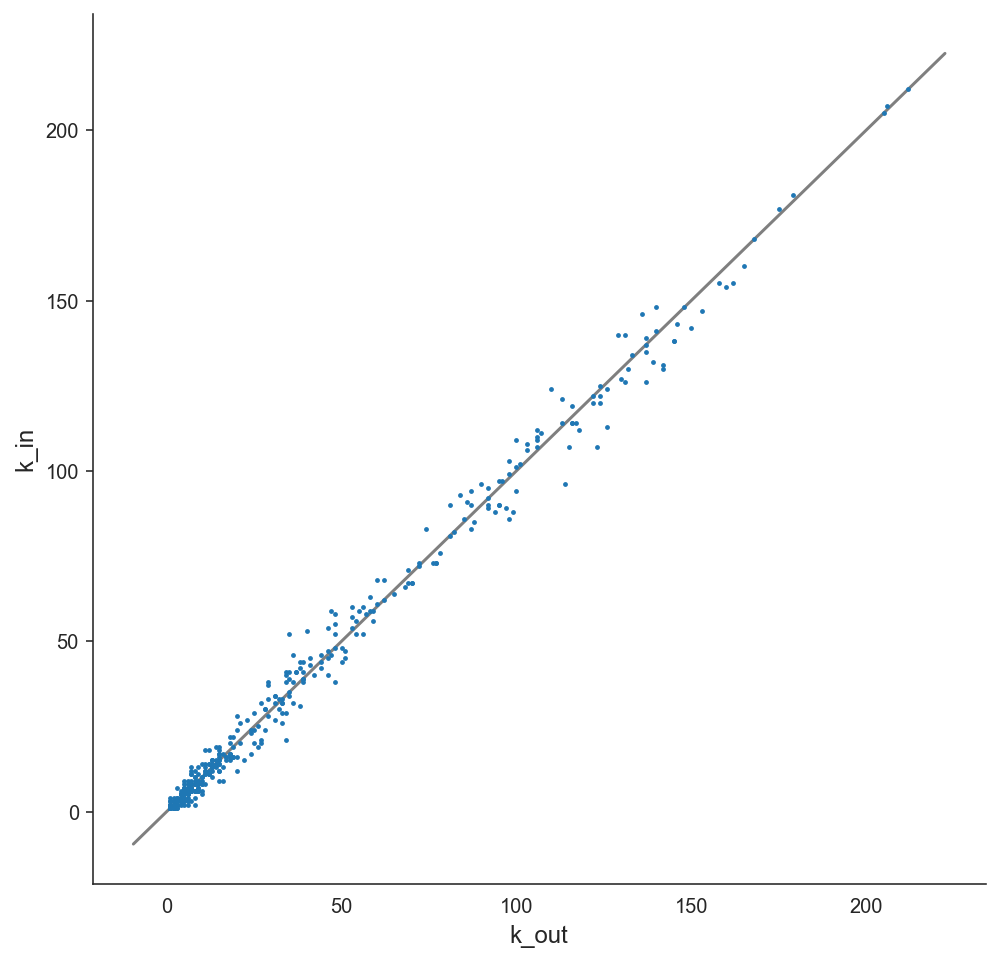

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

ax.scatter(stata.kout, stata.kin, s=2)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)

plt.xlabel('k_out', fontsize=12)
plt.ylabel('k_in', fontsize=12)

fig.show()

In [83]:
print(f"Pearson correlation (k_in & k_out): {round(pearsonr(stata.kout, stata.kin)[0], 3)}")

Pearson correlation (k_in & k_out): 0.996


We can see a strong correlation.

In [84]:
kin_dist = collections.Counter(stata.kin)
kin_dist = collections.OrderedDict(sorted(kin_dist.items()))

In [85]:
kout_dist = collections.Counter(stata.kout)
kout_dist = collections.OrderedDict(sorted(kout_dist.items()))

Now plot the degree distribution, the relative frequency of each value of kin/kout:

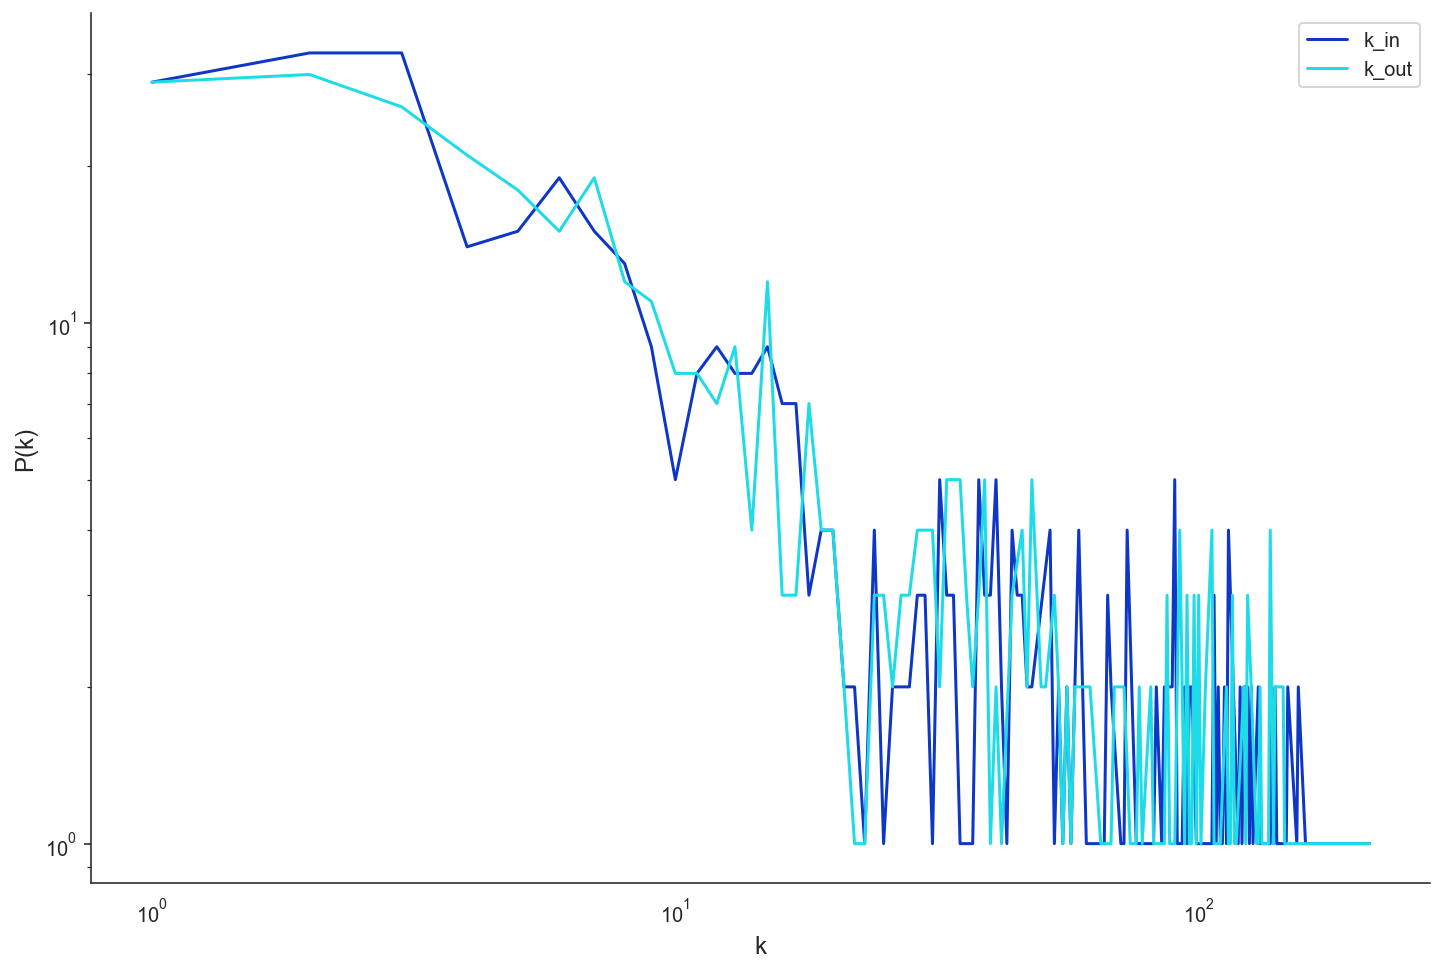

In [86]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax.plot(kin_dist.keys(), kin_dist.values(), color='#0e36c7', label='k_in')
ax.plot(kout_dist.keys(), kout_dist.values(), color='#1edbe8', label='k_out')

plt.xlabel('k', fontsize=12)
plt.ylabel('P(k)', fontsize=12)

plt.legend()

plt.xscale("log")
plt.yscale("log")

fig.show()

## Baseline method

Let's try to predict the Origin-Destination Matrix Prediction. In the initial method, we will not use machine learning, but simply try to predict based on the available data. Let's divide airports into train and sample test. And for a test sample, let's try to predict the flow. It's like we're adding new airports and we want to know the flow for them.
For each airport from the test sample, we will find the nearest airports from the train and watch the flow between the nearest airports found for Origin and Dest from the train. We average the found flows and get predictions

In [30]:
airports = list(df.Origin.unique())

In [31]:
train_airports = np.random.choice(airports, size=int(0.9*len(airports)), replace=False)
test_airports = [x for x in airports if x not in train_airports]

In [32]:
train_df = df[(df.Origin.isin(train_airports)) & (df.Dest.isin(train_airports))]
test_df = df[(df.Origin.isin(test_airports)) | (df.Dest.isin(test_airports))]

In [33]:
def validate_point(p):
    lat, lon = p

def distance_haversine(p1, p2):
    R = 6371 
    lat1, lon1 = p1
    lat2, lon2 = p2
    for p in [p1, p2]:
        validate_point(p)
        
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    d = R * c
    return d

In [34]:
def search_neighbor(point, coord, train_airports, test_airports):
    if point not in test_airports:
        neighbors = [point]
    else:
        distance = {}
        p1 = coord.loc[coord['AIRPORT'] == point].LATITUDE.item(), \
              coord.loc[coord['AIRPORT'] == point].LONGITUDE.item()
        for airport in train_airports:
            p2 = coord.loc[coord['AIRPORT'] == airport].LATITUDE.item(), \
                  coord.loc[coord['AIRPORT'] == airport].LONGITUDE.item()
            distance[airport] = distance_haversine(p1, p2)
        distance = {k: v for k, v in sorted(distance.items(), key=lambda item: item[1])}    
        neighbors = list(distance.keys())
    return neighbors

In [35]:
MAX_NEIGHBORS_CNT = 5
passengers_pred_list = []
for idx in tqdm(range(test_df.shape[0])):
    raw = test_df.iloc[idx]
    origin_neighbors = search_neighbor(raw.Origin, coord, train_airports, test_airports)
    dest_neighbors = search_neighbor(raw.Dest, coord, train_airports, test_airports)
    
    if (len(origin_neighbors) != 1) and (len(dest_neighbors) != 1):
        od_choosen = train_df[(train_df.Origin.isin(origin_neighbors[:MAX_NEIGHBORS_CNT])) \
                              & (train_df.Dest.isin(dest_neighbors[:MAX_NEIGHBORS_CNT]))]
    elif (len(origin_neighbors) == 1) and (len(dest_neighbors) != 1):
        od_choosen = train_df[(train_df.Origin.isin(origin_neighbors)) \
                              & (train_df.Dest.isin(dest_neighbors[:MAX_NEIGHBORS_CNT]))]
    else:
        od_choosen = train_df[(train_df.Origin.isin(origin_neighbors[:MAX_NEIGHBORS_CNT])) \
                              & (train_df.Dest.isin(dest_neighbors))]
        
    if od_choosen.shape[0] == 0:
        passengers_pred = np.nan 
    else:
        passengers_pred = od_choosen.Passengers.mean()
    
    passengers_pred_list.append(passengers_pred)

100%|███████████████████████████████████████| 2745/2745 [07:19<00:00,  6.24it/s]


In [37]:
df_res_baseline = copy.deepcopy(test_df)

In [38]:
df_res_baseline['Passengers_pred'] = [x for x in passengers_pred_list]

It is clear that not for all airports from test there will be neighbors between which there is a flow. For them, we will simply average the predictions received.

In [39]:
df_res_baseline = df_res_baseline.fillna(df_res_baseline.Passengers_pred.mean())

In [40]:
mean_absolute_error(df_res_baseline.Passengers, df_res_baseline.Passengers_pred)

4177.52434210632

In [41]:
df_res_baseline['diff_'] = [abs(x-y) for x,y in zip(df_res_baseline.Passengers, \
                                                    df_res_baseline.Passengers_pred)]

In [42]:
df_res_baseline[['diff_', 'Passengers']].describe()

,diff_,Passengers
count,2745.000000,2745.000000
mean,4177.524342,3551.583607
std,8078.198348,9532.822200
min,0.000000,1.000000
25%,83.000000,2.000000
50%,1926.000000,60.000000
75%,3105.433995,2227.000000
max,87150.500000,87764.000000


The results on metrics turned out to be not very good, to put it mildly, but if you look at the distribution, you can see something good.

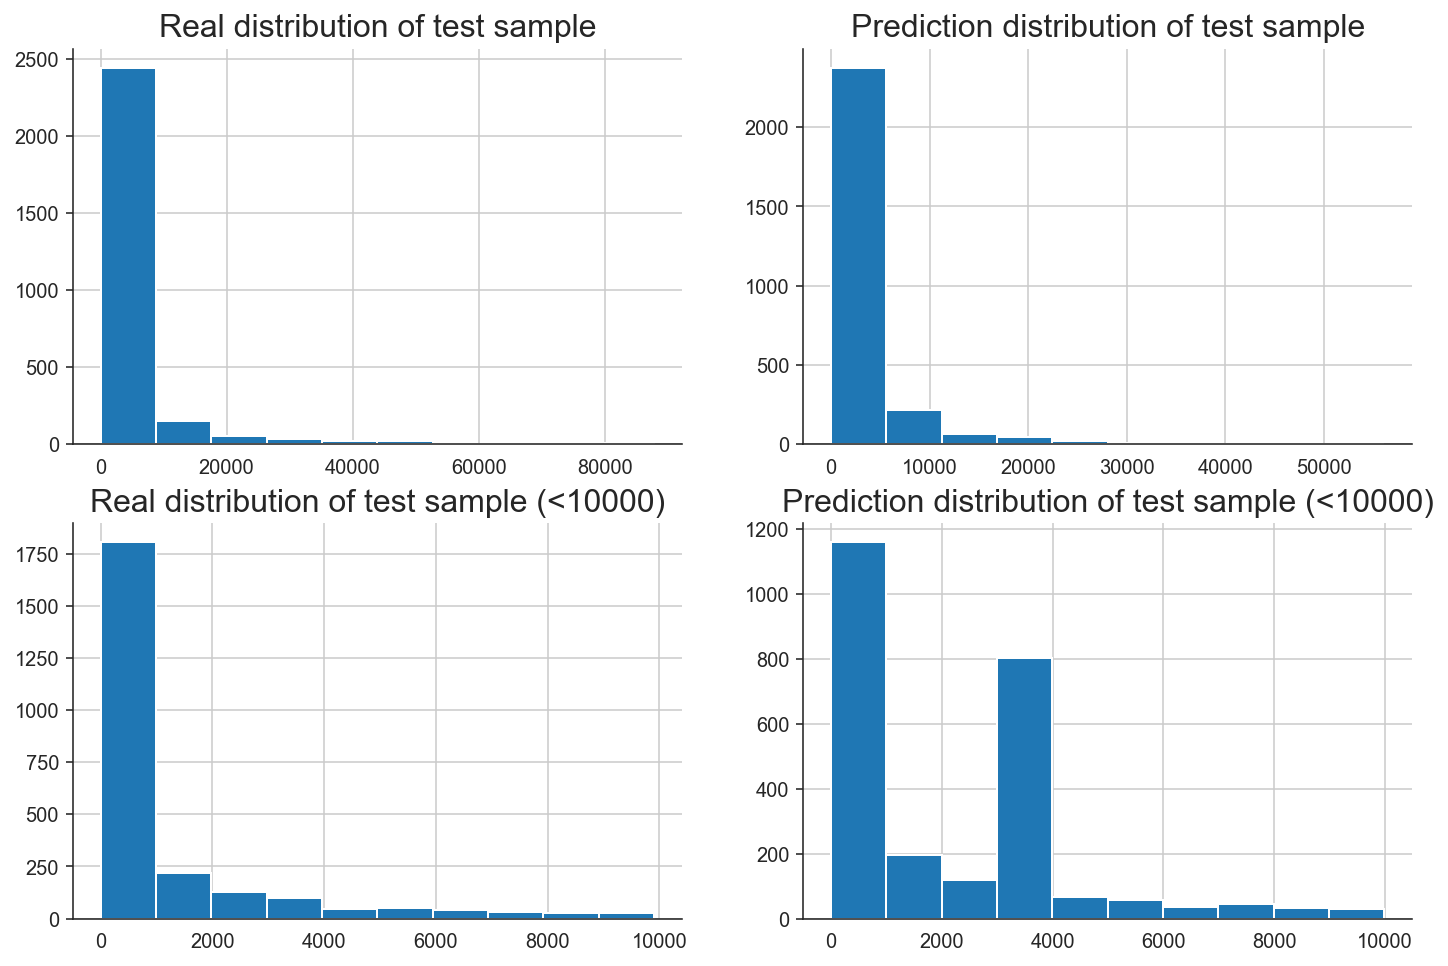

In [43]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 8)

df_res_baseline.Passengers.hist(ax=ax[0,0])
ax[0,0].set_title('Real distribution of test sample', fontsize=16)

df_res_baseline.Passengers_pred.hist(ax=ax[0,1])
ax[0,1].set_title('Prediction distribution of test sample', fontsize=16)

df_res_baseline[df_res_baseline.Passengers < 10000].Passengers.hist(ax=ax[1,0])
ax[1,0].set_title('Real distribution of test sample (<10000)', fontsize=16)

df_res_baseline[df_res_baseline.Passengers_pred < 10000].Passengers_pred.hist(ax=ax[1,1])
ax[1,1].set_title('Prediction distribution of test sample (<10000)', fontsize=16)

fig.show()

It can be seen that the distributions practically coincide. If you look in more detail at up to 10,000 passengers, you can see obvious discrepancies, for example, a bright peak for predictions of up to 4,000 passengers. But it looks good for baseline.

Then there were attempts to predict the Origin-Destination Matrix Production using neural networks, but they were unsuccessful. Therefore, it was decided to simplify the task a little.

### Label prediction by random walk

Let's look at the map again, but on a color scale. With the growth of the flow, not only the size, but also the color of the node changes.

In [161]:
# map_pic/3.png
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)
fig = px.scatter_mapbox(coord_with_passengers,
                        lat=coord_with_passengers.LATITUDE,
                        lon=coord_with_passengers.LONGITUDE,
                        color="Passengers",
                        size="Passengers",
                        color_continuous_scale=px.colors.sequential.Plasma, size_max=15, zoom=2)
fig.show()

Let's divide airports into 3 classes depending on the flow that passes through the airport.

In [89]:
perc33 = coord_with_passengers[['Passengers']].quantile(.33)[0]
perc66 = coord_with_passengers[['Passengers']].quantile(.66)[0]
perc75 = coord_with_passengers[['Passengers']].quantile(.75)[0]

In [90]:
coord_with_passengers['backet'] = [0 if x <= perc33 \
                              else 1 if (x > perc33) and (x <= perc66) \
                              else 2 for x in coord_with_passengers.Passengers]

In [91]:
coord_with_passengers.head()

,AIRPORT,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST,Passengers,backet
0,ABE,40.652500,-75.440278,1,71709.0,2
1,ABI,32.411389,-99.681944,1,13874.0,1
2,ABQ,35.038889,-106.608333,1,326124.0,2
3,ABR,45.446667,-98.422500,1,4832.0,1
4,ABY,31.535556,-84.194444,1,6270.0,1


In [92]:
# map_pic/4.png
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)
fig = px.scatter_mapbox(coord_with_passengers,
                        lat=coord_with_passengers.LATITUDE,
                        lon=coord_with_passengers.LONGITUDE,
                        color="backet",
                        color_continuous_scale=px.colors.sequential.Plasma, size_max=15, zoom=2)
fig.show()

In [93]:
df_new = copy.deepcopy(df)

In [94]:
df_new['Origin'] = [coord_with_passengers.loc[coord_with_passengers['AIRPORT'] == x].index[0] \
                                            for x in df_new.Origin]
df_new['Dest'] = [coord_with_passengers.loc[coord_with_passengers['AIRPORT'] == x].index[0] \
                                            for x in df_new.Dest]

df_new = df_new[['Origin', 'Dest']]
df_new.head()

,Origin,Dest
686,26,264
9295,264,26
8368,234,221
7963,221,234
12286,327,112


In [95]:
coord_with_passengers_new = copy.deepcopy(coord_with_passengers)
coord_with_passengers_new.head()

,AIRPORT,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST,Passengers,backet
0,ABE,40.652500,-75.440278,1,71709.0,2
1,ABI,32.411389,-99.681944,1,13874.0,1
2,ABQ,35.038889,-106.608333,1,326124.0,2
3,ABR,45.446667,-98.422500,1,4832.0,1
4,ABY,31.535556,-84.194444,1,6270.0,1


In [96]:
coord_with_passengers_new['AIRPORT']= [coord_with_passengers.loc[coord_with_passengers['AIRPORT'] == x].index[0] \
                                                   for x in coord_with_passengers_new.AIRPORT]
coord_with_passengers_new.head()

,AIRPORT,LATITUDE,LONGITUDE,AIRPORT_IS_LATEST,Passengers,backet
0,0,40.652500,-75.440278,1,71709.0,2
1,1,32.411389,-99.681944,1,13874.0,1
2,2,35.038889,-106.608333,1,326124.0,2
3,3,45.446667,-98.422500,1,4832.0,1
4,4,31.535556,-84.194444,1,6270.0,1


In [97]:
coord_with_passengers_new = coord_with_passengers_new[['AIRPORT', 'Passengers', 'backet']]
coord_with_passengers_new.head()

,AIRPORT,Passengers,backet
0,0,71709.0,2
1,1,13874.0,1
2,2,326124.0,2
3,3,4832.0,1
4,4,6270.0,1


Label propagation method is also assume that closer data points tend to have similar class labels. Let us denote $Y$ as given label matrix, whose $i$-th row representing the label probability distribution of node $i$. Initialization of rows corresponding to unlabeled data points is not important, but let it be a uniform distribution. The algorithm is
1. Propagate $Y \leftarrow PY$ where $P$ is a transition matrix
2. Recover rows of $Y$ corresponding to labeled data points
3. Row-normalize $Y$ to maintain probability interpretation
4. Repeat 1-3 until $Y$ converges
5. Make a prediction as the most likely labels 

In [98]:
G = nx.from_pandas_edgelist(df_new, 'Origin', 'Dest')

In [99]:
np.random.seed(42)
train_nodes = np.random.choice(G, size=int(0.9*len(G.nodes)), replace=False)
test_nodes = np.array(list(set(G.nodes).difference(train_nodes)))

In [100]:
y_train = [coord_with_passengers_new.loc[coord_with_passengers_new.AIRPORT == x]['backet'].item() \
                                       for x in train_nodes]
y_test = [coord_with_passengers_new.loc[coord_with_passengers_new.AIRPORT == x]['backet'].item() \
                                       for x in test_nodes]

In [101]:
def label_propagation(G, threshold, y_train, train_nodes, test_nodes):
    Y = initital_Y(G, y_train, train_nodes, test_nodes)
    P = transition_matrix(G)
    while True:
        nextY = update_Y(P, Y, y_train, train_nodes, test_nodes)
        if np.linalg.norm(nextY - Y) < threshold:
            break
        Y = nextY
    y_pred = np.argmax(Y, axis=1)[test_nodes]
    return y_pred

In [102]:
def initital_Y(G, y_train, train_nodes, test_nodes):
    len_labels = len(set(y_train))
    Y = [[]] * (len(train_nodes) + len(test_nodes))
    for i in train_nodes:
        Y[i] = [0] * len_labels
        Y[i][y_train[list(train_nodes).index(i)]] = 1
    for i in test_nodes:
        Y[i] = [1/len_labels] * len_labels
    return np.array(Y)

In [103]:
Y = initital_Y(G, y_train, train_nodes, test_nodes)

In [104]:
def transition_matrix(G):
    P = np.eye(len(G))
    for x in G.edges:
        P[x[0]][x[1]] = 1
        P[x[1]][x[0]] = 1
    for i in range(len(G)):
        if np.sum(P[i]) != 0:
            s = np.sum(P[i])
            for j in range(len(G)):
                P[i][j] = P[i][j] / s
    return P

In [105]:
P = transition_matrix(G)

In [106]:
def update_Y(P, Y, y_train, train_nodes, test_nodes):
    Y_new = np.dot(P, Y)
    for i in train_nodes:
        Y_new[i] = Y[i]
    return Y_new

In [116]:
nextY = update_Y(P, Y, y_train, train_nodes, test_nodes)

y_pred = label_propagation(G, 0.01, y_train, train_nodes, test_nodes)

In [120]:
print(f"balanced_accuracy_score = {round(balanced_accuracy_score(y_test, y_pred), 2)}")
print(f"mean_absolute_error = {round(mean_absolute_error(y_test, y_pred), 2)}")

balanced_accuracy_score = 0.38
mean_absolute_error = 0.91


The results are not excellent in metrics, but it can use for an initial approximation.

###  Ridge regression

Consider given node labels $\mathbf y$ and normalized labels

$$\tilde y_i = y_i - \frac{1}{k}\sum_{j=1}^k y_j$$ 

where $k$ is the number of known labels. Unknown labels are given as zeros $\tilde y_i = 0$. Also let $\mathbf f$ be predicted labels of nodes. The objective is to minimize the square loss function plus the smoothness penalty $S$

$$\mathbf{\tilde f} = \text{argmin}_\mathbf{f}\left(\frac{1}{k}\sum_{i=1}^k(f_i - \tilde y_i)^2 + \gamma \mathbf{f}^T S \mathbf{f}\right)$$

we can consider smoothness penalty as some power of graph Laplacian, e.g. $S = L^p$, where $p$ is an integer hyperparameter.
The analytical solution is given as

$$\mathbf{\tilde f} = (k \gamma L^p + I)^{-1}\mathbf{\tilde y}$$

where $I$ is a diagonal matrix with ones and zeros. $I_{ii} = 1$ if a label of $i$-th node is known.

Write a function `tikhonov_regularization` that takes the same parameters as above (`gamma` is a coefficient of regularization, $p$ is a power of Laplacian), and returns predicted labels.

In [110]:
def tikhonov_regularization(G, gamma, y_train, train_nodes, test_nodes, p=2):
    k = len(y_train)
    nodes_cnt = len(train_nodes) + len(test_nodes)
    I = np.eye(nodes_cnt)
    y_ = []
    
    y_train_ = y_train
    
    for node in range(nodes_cnt):
        if node in train_nodes:
            y_.append(y_train_[list(train_nodes).index(node)])
        else:
            y_.append(0)
            I[node][node] = 0
            
    L = np.zeros((nodes_cnt, nodes_cnt))
    
    G_ = list(G.edges)
    edges = sorted(G_, key = lambda x: (x[0], x[1]))
    
    L_dict = {}
    for edge in edges:
        if edge[0] not in L_dict:
            L_dict[edge[0]] = [0,[]]
            
        if edge[1] not in L_dict:
            L_dict[edge[1]] = [0,[]]
            
        L_dict[edge[0]][0] += 1
        L_dict[edge[0]][1].append(edge[1])
        
        L_dict[edge[1]][0] += 1
        L_dict[edge[1]][1].append(edge[0])
    
    for l in L_dict:
        L[l][l] = L_dict[l][0]
        for neigh in L_dict[l][1]:
            L[l][neigh] = -1
    
    if p == 2:
        L = L.dot(L)
    
    y_pred = np.linalg.inv((k * gamma * L + I)).dot(y_) 
    
    y_pred = np.delete(y_pred, train_nodes)   
    
    return y_pred    

In [156]:
y_pred = tikhonov_regularization(G, 0.001, y_train, train_nodes, test_nodes, p=1)
y_pred = [round(x) for x in y_pred]

In [157]:
print(f"balanced_accuracy_score(p=1) = {round(balanced_accuracy_score(y_test, y_pred), 2)}")
print(f"mean_absolute_error(p=1) = {round(mean_absolute_error(y_test, y_pred), 2)}")

balanced_accuracy_score(p=1) = 0.33
mean_absolute_error(p=1) = 0.67


In [158]:
y_pred = tikhonov_regularization(G, 0.001, y_train, train_nodes, test_nodes, p=2)
y_pred = [round(x) for x in y_pred]

In [159]:
print(f"balanced_accuracy_score(p=2) = {round(balanced_accuracy_score(y_test, y_pred), 2)}")
print(f"mean_absolute_error(p=2) = {round(mean_absolute_error(y_test, y_pred), 2)}")

balanced_accuracy_score(p=2) = 0.33
mean_absolute_error(p=2) = 0.67


Get the same results on the metrics for p=1 and p=2. If you look at balanced_accuracy_score, it is better in the random walk, and mean_absolute_error is better in the ridge regression. Therefore, it would be good to try to combine these two methods